In [2]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns

pw = "Dollardollarbillyall"
db = "pokemondb"

In [3]:
def create_db_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password,
            database=db_name,
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

In [4]:
connection = create_db_connection("localhost", "root", pw, db) # Connect to the Database

MySQL Database connection successful


In [5]:
allpokemondf = pd.read_sql("SELECT * FROM pokemon;", connection)
allpokemondf.head()

,id,pokedex_number,name,german_name,japanese_name,generation,status,species,type_number,type_1,...,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
0,0,1,Bulbasaur,Bisasam,フシギダネ (Fushigidane),1,Normal,Seed Pokémon,2,Grass,...,1,2,2,1,1,1,1,1,1,1
1,1,2,Ivysaur,Bisaknosp,フシギソウ (Fushigisou),1,Normal,Seed Pokémon,2,Grass,...,1,2,2,1,1,1,1,1,1,1
2,2,3,Venusaur,Bisaflor,フシギバナ (Fushigibana),1,Normal,Seed Pokémon,2,Grass,...,1,2,2,1,1,1,1,1,1,1
3,3,3,Mega Venusaur,Bisaflor,フシギバナ (Fushigibana),1,Normal,Seed Pokémon,2,Grass,...,1,2,2,1,1,1,1,1,1,1
4,4,4,Charmander,Glumanda,ヒトカゲ (Hitokage),1,Normal,Lizard Pokémon,1,Fire,...,2,1,1,1,2,1,1,1,1,1


I'll first use just base_experience as an indicator for base stat total. How are they correlated?

In [23]:
allpokemondf['base_experience'].isnull().sum()

120

In [28]:
check_for_nan = allpokemondf['base_experience'].isnull()
print (check_for_nan)

0       False
1       False
2       False
3       False
4       False
        ...  
1040     True
1041     True
1042     True
1043     True
1044     True
Name: base_experience, Length: 1045, dtype: bool


I wasn't able to scrape base experience information for generation 8 Pokemon into the database, so I will exclude those Pokemon who are missing base_experience info.

In [24]:
df_without_nan = allpokemondf.dropna(subset = ["base_experience"], axis=0)

In [40]:
df_without_nan["base_experience"].isnull().values.any()

False

In [134]:
from sklearn import linear_model
lm = linear_model.LinearRegression()

In [105]:
indicator = df_without_nan[["base_experience"]]
target = df_without_nan["total_points"]

In [106]:
lm.fit(indicator, target)

LinearRegression()

In [46]:
Yhat = lm.predict(indicator)

In [57]:
intercept1 = lm.intercept_
slope1 = lm.coef_

In [60]:
print("The relationship between base experience and base stat total is given by: \n base stat total = "+str(slope1)+"*base experience + " + str(intercept1))

The relationship between base experience and base stat total is given by: 
 base stat total = [1.40722357]*base experience + 221.4807507455265


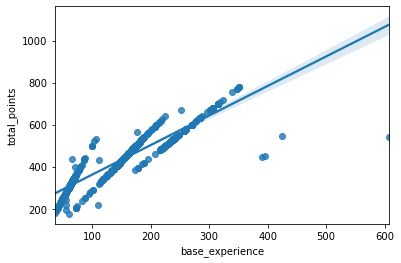

In [63]:
sns.regplot(x="base_experience", y="total_points", data=df_without_nan);

Let's now get the coefficient of determation, or R^2, for this regression.

In [107]:
print("The R^2 value for this regression is "+ str(lm.score(indicator, target)))

The R^2 value for this regression is 0.8642116101614545


The maximum value for R^2 is 1, so this is a pretty good fit. I can also check how well the regression fits by looking at the residuals plot below.

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='base_experience', ylabel='total_points'>

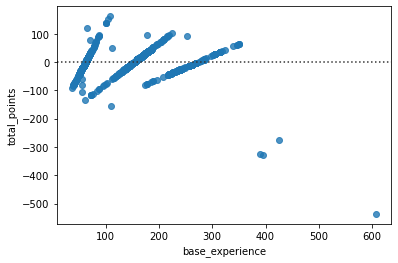

In [91]:
sns.residplot(df_without_nan["base_experience"], df_without_nan["total_points"])

To look at some other possible predictor variables, I will check the correlation of each attribute of each Pokemon with its base stat total (BST, listed as "total_points" in the dataframe). The closer to 1 or -1, the stronger the correlation.

In [78]:
pokemon_correlation = allpokemondf.corr()
pokemon_correlation[["total_points"]].style.background_gradient(cmap='Blues')

,total_points
id,0.137483
pokedex_number,0.136512
generation,0.091050
type_number,0.212363
height_m,0.376983
weight_kg,0.477183
abilities_number,-0.432820
total_points,1.000000
hp,0.650568
attack,0.733028


Based on this correlation list, all of the stats (hp, attack, defense, etc.) show strong positive correlation with base stat total (BST) and catch rate shows strong negative correlation. I will use thse indicator varaibles in my next model. 

Remake the linear regression object to reuse variable name

In [136]:
lm = linear_model.LinearRegression()

In [137]:
df_without_nan = allpokemondf.dropna(subset = ["base_experience", "catch_rate"], axis=0)

In [138]:
Z = df_without_nan[["base_experience", "catch_rate"]]

In [139]:
lm.fit(Z, df_without_nan["total_points"])
intercept2 = lm.intercept_
#this is an array of slopes, so in this case there are two slopes
slope2 = lm.coef_

In [140]:
print("The relationship between BST, base experience, and catch rate is given by: \n base stat total = "+str(slope2[0])+"*base experience + " + str(slope2[1])+ "*catch rate + "+ str(intercept2))

The relationship between BST, base experience, and catch rate is given by: 
 base stat total = 1.2283218886369163*base experience + -0.2740607619353496*catch rate + 274.5444366476087


Besides R^2, another way to check how well a regression predicts the data is by looking at the Mean Squared Error. I can do that with the following.

In [141]:
from sklearn.metrics import mean_squared_error

In [142]:
MSE = mean_squared_error(df_without_nan["total_points"], lm.predict(Z))

In [143]:
print("The Mean Squared Error (MSE) for this linear regression is "+str(MSE))

The Mean Squared Error (MSE) for this linear regression is 1729.6765058006165


## Distribution plot

One final way to visualize how well this model fits the data is to look at a distribution plot that compares the actual data to that predicted by the model. The first step is to use the model to guess what each value of BST should be for each Pokemon. I do that wih the following line of code:

In [144]:
Y_hat = lm.predict(Z)

Where Y hat is the mathematical convention for calculated value using a model like this. Now it's time to plot the actual values compared to the calculated ones.

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


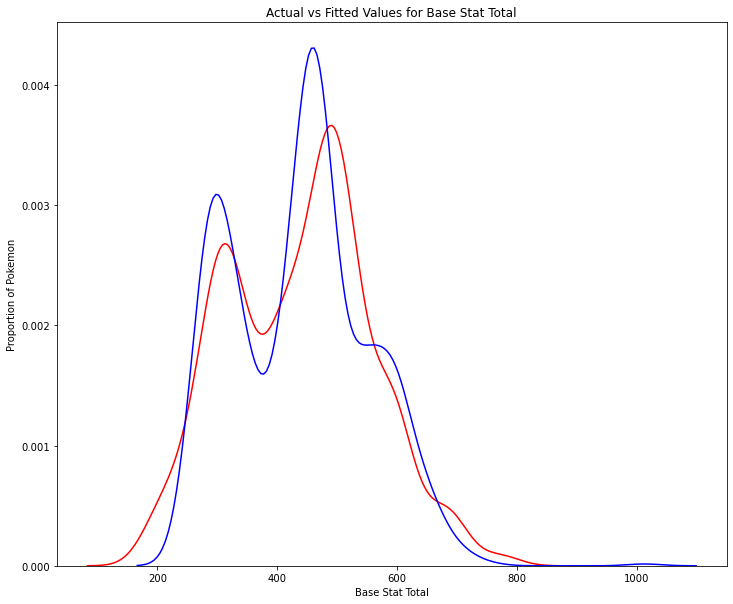

In [147]:
width = 12
height = 10

plt.figure(figsize=(width, height))


ax1 = sns.distplot(df_without_nan['total_points'], hist=False, color="r", label="Actual Value")
sns.distplot(Y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Base Stat Total')
plt.xlabel('Base Stat Total')
plt.ylabel('Proportion of Pokemon')

plt.show()
plt.close()

Visually, this looks pretty good! The more overlap between the model and the actual values, the more accurate it is. If a linear regression isn't cutting it, I could instead turn to polynomial fits as I will describe below.

## Below I will fit polynomial, rather than linear, functions to fit base_experience to BST and catch_rate to BST respectively

In [108]:
def PlotPolly(model, independent_variable, dependent_variabble, Name):
    x_new = np.linspace(15, 55, 100)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variabble, '.', x_new, y_new, '-')
    plt.title('Polynomial Fit with Matplotlib for Base Stat Total')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('Base Stat Total')

    plt.show()
    plt.close()

In [111]:
x = df_without_nan['base_experience']
y = df_without_nan['total_points']

In [112]:
# Here we use a polynomial of the 3rd order (cubic) 
f = np.polyfit(x, y, 3)
p = np.poly1d(f)
print(p)

            3             2
-3.707e-06 x + 0.0004219 x + 1.673 x + 193.2


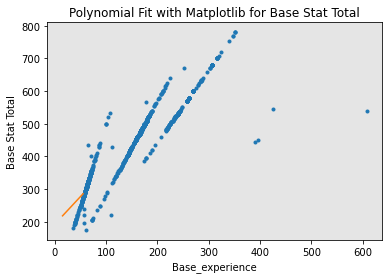

In [113]:
PlotPolly(p, x, y, 'Base_experience')

In [126]:
x1 = df_without_nan['catch_rate']
y1 = df_without_nan['total_points']

In [129]:
# Here we use a polynomial of the 11th order 
f = np.polyfit(x1, y1, 11)
p = np.poly1d(f)
print(p)

           11             10             9             8             7
1.573e-20 x  - 1.549e-17 x  + 6.074e-15 x - 1.261e-12 x + 1.861e-10 x
              6             5             4           3         2
 - 3.215e-08 x + 5.715e-06 x - 0.0006597 x + 0.04113 x - 1.199 x + 9.286 x + 602.8


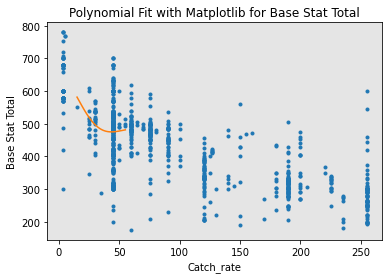

In [130]:
PlotPolly(p, x1, y1, 'Catch_rate')